# 📝 Exercise M6.03

The aim of this exercise is to:

* verifying if a random forest or a gradient-boosting decision tree overfit
  if the number of estimators is not properly chosen;
* use the early-stopping strategy to avoid adding unnecessary trees, to
  get the best generalization performances.

We will use the California housing dataset to conduct our experiments.

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0, test_size=0.5)

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">If you want a deeper overview regarding this dataset, you can refer to the
Appendix - Datasets description section at the end of this MOOC.</p>
</div>

Create a gradient boosting decision tree with `max_depth=5` and
`learning_rate=0.5`.

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate

gradient_boosting = GradientBoostingRegressor(
    n_estimators=200, learning_rate=0.5, max_depth=5
)

cv_results_gbdt = cross_validate(
    gradient_boosting, data, target, scoring="neg_mean_absolute_error",
    n_jobs=2,
)

cv_results_gbdt

{'fit_time': array([5.24431324, 5.27364421, 5.31600165, 5.37155747, 5.07270002]),
 'score_time': array([0.00936389, 0.00933409, 0.00950575, 0.00968099, 0.00905609]),
 'test_score': array([-36.64364453, -36.03610343, -34.82029151, -37.78800397,
        -35.35737281])}


Also create a random forest with fully grown trees by setting `max_depth=None`.

In [18]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators=200, max_depth=None)

cv_results_rf = cross_validate(
    random_forest, data, target, scoring="neg_mean_absolute_error",
    n_jobs=2,
)

cv_results_rf

{'fit_time': array([8.92583203, 8.93639898, 8.66072106, 8.6686945 , 8.68648148]),
 'score_time': array([0.12225723, 0.12408733, 0.12180805, 0.12185025, 0.12041259]),
 'test_score': array([-35.3076335 , -35.46522636, -33.72161855, -35.65328435,
        -33.25062595])}


For both the gradient-boosting and random forest models, create a validation
curve using the training set to assess the impact of the number of trees on
the performance of each model. Evaluate the list of parameters `param_range =
[1, 2, 5, 10, 20, 50, 100]` and use the mean absolute error.

In [19]:
from sklearn.model_selection import validation_curve

param_range = [1, 2, 5, 10, 20, 50, 100]

train_scores_gbdt, test_scores_gbdt = validation_curve(
    gradient_boosting,
    data,
    target,
    param_name="max_depth",
    param_range=param_range,
    scoring="neg_mean_absolute_error",
    n_jobs=2,
)

train_scores_rf, test_scores_rf = validation_curve(
    random_forest,
    data,
    target,
    param_name="max_depth",
    param_range=param_range,
    scoring="neg_mean_absolute_error",
    n_jobs=2,
)

In [20]:
import numpy as np

train_scores_mean_gbdt = np.mean(train_scores_gbdt, axis=1)
test_scores_mean_gbdt = np.mean(test_scores_gbdt, axis=1)

train_scores_mean_rf = np.mean(train_scores_rf, axis=1)
test_scores_mean_rf = np.mean(test_scores_rf, axis=1)

In [21]:
test_scores_mean_gbdt

array([-41.81514203, -35.26933811, -36.14818999, -37.93667884,
       -45.65142832, -47.83392834, -48.02980149])

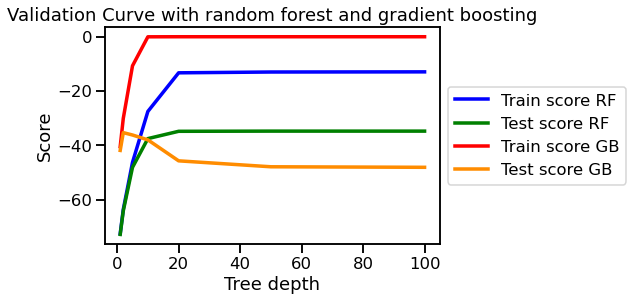

In [22]:
import matplotlib.pyplot as plt

plt.title("Validation Curve with random forest and gradient boosting")
plt.xlabel(r"Tree depth")
plt.ylabel("Score")


plt.plot(
    param_range, train_scores_mean_rf, label="Train score RF",
    color="blue")

plt.plot(
    param_range, test_scores_mean_rf, label="Test score RF",
    color="green")

plt.plot(
    param_range, train_scores_mean_gbdt, label="Train score GB",
    color="red")

plt.plot(
    param_range, test_scores_mean_gbdt, label="Test score GB",
    color="darkorange")


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Both gradient boosting and random forest models will always improve when
increasing the number of trees in the ensemble. However, it will reach a
plateau where adding new trees will just make fitting and scoring slower.

To avoid adding new unnecessary tree, unlike random-forest gradient-boosting
offers an early-stopping option. Internally, the algorithm will use an
out-of-sample set to compute the generalization performance of the model at
each addition of a tree. Thus, if the generalization performance is not
improving for several iterations, it will stop adding trees.

Now, create a gradient-boosting model with `n_estimators=1_000`. This number
of trees will be too large. Change the parameter `n_iter_no_change` such
that the gradient boosting fitting will stop after adding 5 trees that do not
improve the overall generalization performance.

In [23]:
gradient_boosting_2 = GradientBoostingRegressor(
    n_estimators=1000, learning_rate=0.5, max_depth=5, n_iter_no_change=5
)

cv_results_gbdt_2 = cross_validate(
    gradient_boosting_2, data, target, scoring="neg_mean_absolute_error",
    n_jobs=2,
)

cv_results_gbdt_2

{'fit_time': array([1.37740564, 2.25042892, 2.33450317, 2.17340946, 2.17956281]),
 'score_time': array([0.00386453, 0.00497699, 0.00564432, 0.00482869, 0.00505018]),
 'test_score': array([-47.20881505, -45.37962553, -47.38482087, -70.05618294,
        -50.17487771])}

Estimate the generalization performance of this model again using
the `sklearn.metrics.mean_absolute_error` metric but this time using
the test set that we held out at the beginning of the notebook.
Compare the resulting value with the values observed in the validation
curve.

In [25]:
gradient_boosting_2.fit(data_train, target_train)

gradient_boosting_2.score(data_test, target_test) # sklearn.metrics.mean_absolute_error

0.7925677338870254